In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from fastapi import FastAPI
import uvicorn

In [25]:
sales_train = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
item_categories = pd.read_csv("item_categories.csv")
test = pd.read_csv("test.csv")

In [26]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_monthly.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [27]:
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
sales_monthly = sales_monthly.merge(shops[['shop_id']], on='shop_id', how='left')

In [28]:
monthly_total = sales_monthly.groupby('date_block_num')['item_cnt_month'].sum()
plt.figure(figsize=(10, 6))
plt.plot(monthly_total.index, monthly_total.values)
plt.title("Total Monthly Sales Over Time")
plt.xlabel("Date Block Number (0 = Jan 2013, 33 = Oct 2015)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig('sales_trend.png')
plt.close()

In [29]:
Q1 = sales_monthly['item_cnt_month'].quantile(0.25)
Q3 = sales_monthly['item_cnt_month'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (sales_monthly['item_cnt_month'] >= Q1 - 1.5 * IQR) & (sales_monthly['item_cnt_month'] <= Q3 + 1.5 * IQR)
sales_monthly = sales_monthly[outlier_mask]

In [30]:
date_range = range(0, 34)
shop_ids = sales_train['shop_id'].unique()
item_ids = sales_train['item_id'].unique()

In [31]:
grid = []
for date_block in date_range:
    for shop in shop_ids:
        for item in item_ids:
            grid.append([date_block, shop, item])
grid = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

print(grid)

          date_block_num  shop_id  item_id
0                      0       59    22154
1                      0       59     2552
2                      0       59     2554
3                      0       59     2555
4                      0       59     2564
...                  ...      ...      ...
44486275              33       36     8428
44486276              33       36     7903
44486277              33       36     7610
44486278              33       36     7635
44486279              33       36     7640

[44486280 rows x 3 columns]


In [32]:
sales_monthly = grid.merge(sales_monthly, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

In [33]:
for lag in [1, 2, 3]:
    shifted = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    sales_monthly[f'lag_{lag}'] = shifted

In [34]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_monthly.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
sales_monthly = sales_monthly.merge(shops[['shop_id']], on='shop_id', how='left')

print("Aggregated Monthly Sales Data:")
display(sales_monthly.head())

Aggregated Monthly Sales Data:


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57


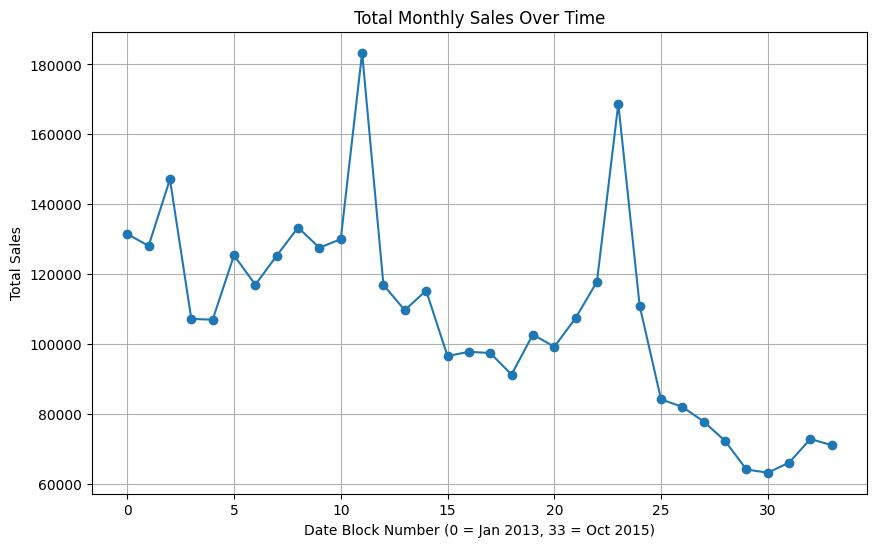

In [35]:
monthly_total = sales_monthly.groupby('date_block_num')['item_cnt_month'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_total.index, monthly_total.values, marker='o')
plt.title("Total Monthly Sales Over Time")
plt.xlabel("Date Block Number (0 = Jan 2013, 33 = Oct 2015)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig('sales_trend.png')
plt.show()

In [39]:
Q1 = sales_monthly['item_cnt_month'].quantile(0.25)
Q3 = sales_monthly['item_cnt_month'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (sales_monthly['item_cnt_month'] >= Q1 - 1.5 * IQR) & (sales_monthly['item_cnt_month'] <= Q3 + 1.5 * IQR)

print(f"Number of outliers: {len(sales_monthly) - outlier_mask.sum()}")

sales_monthly = sales_monthly[outlier_mask]

print("Stats after removing outliers:")
display(sales_monthly['item_cnt_month'].describe())

Number of outliers: 0
Stats after removing outliers:


count    1.430137e+06
mean     1.328201e+00
std      6.070069e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: item_cnt_month, dtype: float64

In [37]:
date_range = range(0, 34)

shop_ids = sales_train['shop_id'].unique()
item_ids = sales_train['item_id'].unique()

grid = []
for date_block in date_range:
    for shop in shop_ids:
        for item in item_ids:
            grid.append([date_block, shop, item])

grid = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

print(f"Grid shape: {grid.shape}")
display(grid.head())

Grid shape: (44486280, 3)


,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [42]:
print("Current columns in sales_monthly:", sales_monthly.columns)
sales_monthly['item_category_id'] = sales_monthly['item_category_id_y']

sales_monthly = sales_monthly.drop(columns=['item_category_id_x', 'item_category_id_y'])

print("Updated columns in sales_monthly:", sales_monthly.columns)
display(sales_monthly.head())

Current columns in sales_monthly: Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id_x', 'item_category_id_y'],
      dtype='object')
Updated columns in sales_monthly: Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id'],
      dtype='object')


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,59,22154,1.0,37
1,0,59,2552,0.0,58
2,0,59,2554,0.0,58
3,0,59,2555,0.0,56
4,0,59,2564,0.0,59


In [ ]:
print("Unique Shop IDs:", sales_monthly['shop_id'].nunique())
print("Unique Item IDs:", sales_monthly['item_id'].nunique())
print("Unique Item Category IDs:", sales_monthly['item_category_id'].nunique())
print("\nData Types:")
display(sales_monthly.dtypes)

Unique Shop IDs: 60
Unique Item IDs: 21807
Unique Item Category IDs: 84

Data Types:


date_block_num        int64
shop_id               int64
item_id               int64
item_cnt_month      float64
lag_1               float64
lag_2               float64
lag_3               float64
rolling_mean        float64
price_trend         float64
item_category_id      int64
dtype: object

In [ ]:
for lag in [1, 2, 3]:
    shifted = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    sales_monthly[f'lag_{lag}'] = shifted

sales_monthly[['lag_1', 'lag_2', 'lag_3']] = sales_monthly[['lag_1', 'lag_2', 'lag_3']].fillna(0)

print("Sales Monthly Data with Lag Features:")
display(sales_monthly.head())

Sales Monthly Data with Lag Features:


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id_x,item_category_id_y,lag_1,lag_2,lag_3
0,0,59,22154,1.0,37.0,37,0.0,0.0,0.0
1,0,59,2552,0.0,NaN,58,0.0,0.0,0.0
2,0,59,2554,0.0,NaN,58,0.0,0.0,0.0
3,0,59,2555,0.0,NaN,56,0.0,0.0,0.0
4,0,59,2564,0.0,NaN,59,0.0,0.0,0.0


In [ ]:
sales_monthly['rolling_mean'] = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

sales_monthly['rolling_mean'] = sales_monthly['rolling_mean'].fillna(0)

print("Sales Monthly Data with Rolling Mean:")
display(sales_monthly.head())

Sales Monthly Data with Rolling Mean:


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id_x,item_category_id_y,lag_1,lag_2,lag_3,rolling_mean
0,0,59,22154,1.0,37.0,37,0.0,0.0,0.0,1.0
1,0,59,2552,0.0,NaN,58,0.0,0.0,0.0,0.0
2,0,59,2554,0.0,NaN,58,0.0,0.0,0.0,0.0
3,0,59,2555,0.0,NaN,56,0.0,0.0,0.0,0.0
4,0,59,2564,0.0,NaN,59,0.0,0.0,0.0,0.0


In [ ]:
price_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].mean().reset_index()

sales_monthly = sales_monthly.merge(price_data, on=['date_block_num', 'shop_id', 'item_id'], how='left')

sales_monthly['item_price'] = sales_monthly['item_price'].fillna(0)

sales_monthly['price_trend'] = sales_monthly.groupby(['shop_id', 'item_id'])['item_price'].pct_change().fillna(0)

sales_monthly = sales_monthly.drop(columns=['item_price'])

print("Sales Monthly Data with Price Trends:")
display(sales_monthly.head())

Sales Monthly Data with Price Trends:


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id_x,item_category_id_y,lag_1,lag_2,lag_3,rolling_mean,price_trend
0,0,59,22154,1.0,37.0,37,0.0,0.0,0.0,1.0,0.0
1,0,59,2552,0.0,NaN,58,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0.0,NaN,58,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0.0,NaN,56,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0.0,NaN,59,0.0,0.0,0.0,0.0,0.0


In [ ]:
features = ['shop_id', 'item_id', 'item_category_id', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'price_trend']
target = 'item_cnt_month'

train_data = sales_monthly[sales_monthly['date_block_num'] < 33]
val_data = sales_monthly[sales_monthly['date_block_num'] == 33]

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

KeyError: "['item_category_id'] not in index"

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAE: {xgb_mae}")

In [ ]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_scaled = scaler_features.fit_transform(sales_monthly[features])
y_scaled = scaler_target.fit_transform(sales_monthly[[target]])

def create_lstm_dataset(X, y, timesteps=3):
    X_lstm, y_lstm = [], []
    for i in range(timesteps, len(X)):
        X_lstm.append(X[i-timesteps:i])
        y_lstm.append(y[i])
    return np.array(X_lstm), np.array(y_lstm)

timesteps = 3
X_lstm, y_lstm = create_lstm_dataset(X_scaled, y_scaled, timesteps)

train_size = len(X_lstm) - len(val_data)
X_lstm_train = X_lstm[:train_size]
y_lstm_train = y_lstm[:train_size]
X_lstm_val = X_lstm[train_size:]
y_lstm_val = y_lstm[train_size:]

print("LSTM Training set shape (X_lstm_train, y_lstm_train):", X_lstm_train.shape, y_lstm_train.shape)
print("LSTM Validation set shape (X_lstm_val, y_lstm_val):", X_lstm_val.shape, y_lstm_val.shape)